In this notebook, a network  similar to Let there be Color! by Iizuka et al. will be done.Due to limited resources the network and the images used will be much smaller than the regular paper. Diferently from more popular methods it is not self-supervised, although it can be. This also gives us an example of a multi objective network.

In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics.functional import accuracy as accuracy_function
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import TensorDataset
import cv2
import numpy as np
from pytorch_lightning.loggers import TensorBoardLogger


C:\Users\ASUS\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ASUS\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\ASUS\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
print(torch.cuda.is_available())

True


In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ],
)

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


First we need to convert our rgb images to l*ab for that we will use opencv. We will need to get the means and standard deviation for denormalizing the images later

In [4]:
grayscaler = torchvision.transforms.Grayscale()
def convert_tensor_image(image,dst_format):
    numpy_lab_image = np.transpose(image.numpy(), (1, 2, 0))
    numpy_lab_image = cv2.cvtColor(numpy_lab_image, dst_format)
    return torch.from_numpy(np.transpose(numpy_lab_image, (2,0,1)))
def rgb_dataset_to_lab_grayscale(dataset):
    rgb_images = []
    labels=[]
    lab_images = []
    grayscale_images = []
    for image, label in dataset:
        rgb_images.append(image)
        labels.append(label)
        grayscale_images.append(grayscaler(image))
    for rgb_image in rgb_images:
        lab_images.append(convert_tensor_image(rgb_image,cv2.COLOR_RGB2LAB))
    return lab_images,labels,grayscale_images


def l_ab_dataset_from_components(lab_images,labels,grayscale_images):
    lab_images = torch.stack(lab_images)   
    grayscale_images = torch.stack(grayscale_images)
    gr_mean,gr_std = torch.std_mean(grayscale_images,(0,2,3))
    grayscale_normalizer = transforms.Normalize(gr_mean[0].item(), gr_std[0].item())
    l_images = lab_images[:,0,:,:]
    ab_images = lab_images[:,1:,:,:]
    ab_min = torch.min(ab_images)
    ab_max = torch.max(ab_images)
    ab_images = (ab_images - ab_min)/(ab_max-ab_min)
    labels = torch.Tensor(labels)
    newset = TensorDataset(grayscale_normalizer(grayscale_images),l_images,ab_images,labels)
    return newset
trainset = l_ab_dataset_from_components(*rgb_dataset_to_lab_grayscale(trainset))
test_lab_images,test_labels,test_grayscale_images = rgb_dataset_to_lab_grayscale(testset)
testset = l_ab_dataset_from_components(test_lab_images,test_labels,test_grayscale_images)


In [5]:
test_ab_images = torch.stack(test_lab_images)[:,1:,:,:]
test_ab_min = torch.min(test_ab_images)
test_ab_max = torch.max(test_ab_images)

Alph is a hyperparameter for the loss, we use their default value 1/300

In [6]:
batch_size = 32
alpha = 1/300
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=1
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=1
)


The key layer for this paper was a fusion layer to combine linear and 2d features, which is implemented here:

In [7]:
class FuseLinearWithImage(nn.Module):
    def __init__(self, in_channels,
        out_channels,in_features,image_size):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels=out_channels, kernel_size=1,bias=True
        )
        self.linear = nn.Linear(in_features,out_channels)
        self.image_size = image_size

    def forward(self, features):
        
        linear_features,image_features = features
        out_features = self.linear(linear_features)
        out_image = self.conv(image_features)
        
        features =torch.unsqueeze(torch.unsqueeze(out_features,-1),-1)
        features = features.repeat(1,1,self.image_size,self.image_size)
        features += out_image
        return features

In [8]:
class Colorizer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.low_level_features = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=True),
                                   nn.ReLU(True),
                                   nn.BatchNorm2d(64),
                                   nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.ReLU(True),
                                   nn.BatchNorm2d(128))
        self.mid_level_features = nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.ReLU(True),
                                   nn.BatchNorm2d(64))
        self.global_features = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),
                                   nn.ReLU(True),
                                   nn.BatchNorm2d(128),
                                    nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),
                                   nn.ReLU(True),
                                   nn.BatchNorm2d(128),
                                    nn.Flatten(),
                                    nn.Linear(128*4*4,64),
                                    nn.ReLU(True),
                                    nn.BatchNorm1d(64)
                                                  )
        self.classifier = nn.Sequential(nn.Linear(64,10))
        self.colorization_network = nn.Sequential(
                                    FuseLinearWithImage(64,128,64,16),
                                    nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.ReLU(True),
                                   nn.BatchNorm2d(128),
                                   nn.Upsample(scale_factor=2, mode='bilinear'),
                                   nn.ReLU(True),
                                   nn.BatchNorm2d(128),
                                   nn.Conv2d(128, 2, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.Sigmoid()
                                   )
        self.loss_function_image = nn.MSELoss()
        self.loss_function_classifier = nn.CrossEntropyLoss()
        self.model = torch.nn.ModuleList((self.low_level_features,self.mid_level_features,self.global_features,self.classifier,self.colorization_network))

    def forward(self, x):
        x = self.low_level_features(x)
        mid_x = self.mid_level_features(x)
        global_x=self.global_features(x)
        
        return (self.classifier(global_x),self.colorization_network((global_x,mid_x)))
    def generic_step(self,batch,batch_idx):

        grayscale_images,l_images,ab_images,y = batch 
        y_hat,ab_hat = self.forward(grayscale_images)
        loss_image = self.loss_function_image(ab_hat, ab_images)
        loss_classifier = self.loss_function_classifier(y_hat, y.long())
        accuracy = accuracy_function(y_hat,target=y.type(torch.int))
        loss = loss_image + alpha*loss_classifier
        return loss,accuracy

    def training_step(self, batch, batch_idx):
        loss,accuracy = self.generic_step(batch,batch_idx)
        return loss
     

    def validation_step(self, batch, batch_idx):
        loss,accuracy = self.generic_step(batch,batch_idx)
        return accuracy
    def test_step(self, batch, batch_idx):
        loss,accuracy = self.generic_step(batch,batch_idx)
        self.log("test_accuracy_batch", accuracy, prog_bar=True)
        return accuracy
    def test_step_end(self, outs):
        accuracy = torch.mean(outs)
        self.log("test_accuracy",accuracy, prog_bar=True)
    def validation_epoch_end(self, outs):
        accuracy = torch.stack(outs).mean()
        self.log("val_accuracy", accuracy, prog_bar=True)
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer

In [115]:
trainer = pl.Trainer(max_epochs=50,accelerator="gpu", devices=1)
model = Colorizer()
trainer.fit(model, trainloader,testloader)
print("Done")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type             | Params
--------------------------------------------------------------
0 | low_level_features       | Sequential       | 74.9 K
1 | mid_level_features       | Sequential       | 73.9 K
2 | global_features          | Sequential       | 426 K 
3 | classifier               | Sequential       | 650   
4 | colorization_network     | Sequential       | 167 K 
5 | loss_function_image      | MSELoss          | 0     
6 | loss_function_classifier | CrossEntropyLoss | 0     
7 | model                    | ModuleList       | 743 K 
--------------------------------------------------------------
743 K     Trainable params
0         Non-trainable params
743 K     Total params
2.974     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Done


In [9]:
model = Colorizer()
model = model.load_from_checkpoint(checkpoint_path="train.ckpt")

Now let use try seeing an example on how it works. Since we are working with normalized lab images we should denormalize them before converting them back. 

In [30]:
model.eval().to('cpu')
sample_grayscale,sample_l,sample_ab,_ = testset[10:22]
sample_outs = model(sample_grayscale)[1].detach()
sample_ab = sample_ab*(test_ab_max-test_ab_min) + test_ab_min
sample_outs =sample_outs*(test_ab_max-test_ab_min) + test_ab_min 
sample_l = torch.unsqueeze(sample_l,1)
sample_lab_infer = torch.cat((sample_l,sample_outs),dim=1)
sample_lab_grounds = torch.cat((sample_l,sample_ab),dim=1)
sample_outputs =[]
sample_grounds=[]
sample_total = []
for index in range(12):
    index_lab_grounds = sample_lab_grounds[index]
    index_lab_infer = sample_lab_infer[index]
    sample_total.append(convert_tensor_image(index_lab_infer,cv2.COLOR_LAB2RGB))
    sample_total.append(convert_tensor_image(index_lab_grounds,cv2.COLOR_LAB2RGB))

The images will be in the order infered vs ground

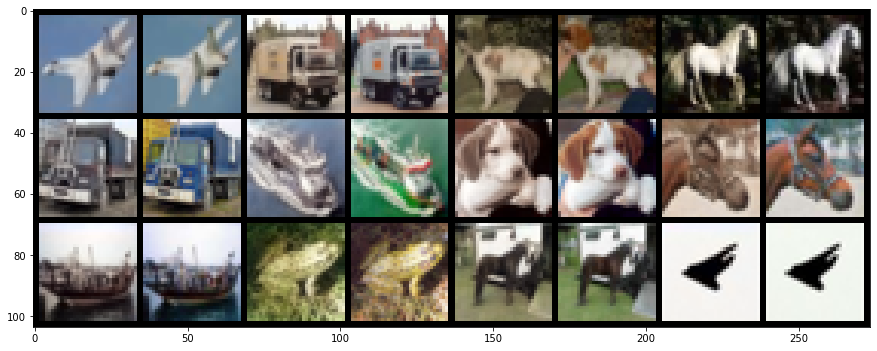

In [31]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,20)
sample_tensor = torch.stack(sample_total)
grid = torchvision.utils.make_grid(sample_tensor)
plt.imshow(grid.permute(1, 2, 0))

There we have it. It should be noticed that we are not aiming at an equal color reconstroction, but rather a realistic coloration so e.g. the trucks with different colors are plausible. It is possible that alpha should be different due to the changes.